# Stakeholder

A real estate company, BlackSock, is looking to invest in King County houses. Their plan is to buy these homes, rent them out for a duration of time, and then sell them after their value increases a satisfactory amount. To maximize profits, this company wants information on several factors that influence the price of such homes.

# Data Origin & Description

The data was taken from https://info.kingcounty.gov/assessor/DataDownload/default.aspx

Descriptions of any of the original variables can be found at https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r


Important variables in the original dataset include:

- the date a house was sold & built
- the price it was sold for
- the square footage of:
    - living space
    - space above grade (everything except the basement)
    - patio
    - garage
    - lot
- number of floors, bedrooms, and bathrooms
- home quality (called 'grade' in the dataset)
- the latitude & longitude
- address

Although not exhaustive, the dataset we're using is comprehensive enough to allow us to build a model that gives our stakeholder some inital insights into what factors influence a house's price.

# Rationale & Limitations

#### Why are you using linear regression?
I am using linear regression in this project to identify home features that are influential in home price, and how influential those features are.

#### What about the current problem makes linear regression suitable?
Linear regression is a form of statistical modeling, which allows us to better understand the relationships between data and make predictions about unseen data. In this case, linear regression can:

- tell us how much certain independent variables influence a dependent variable (price)
    - This is directly relevant to the stakeholder's problem
- yields a formula which allows us to predict the price of a home based on data we've collected.
    - This is also directly relevant to the stakeholder's problem

#### Assumptions of our model
- The independent variables must have a linear relationship with the dependent variable;
- The independent variables must not be collinear;
- The model residuals must follow a normal distribution;
- The predictions made by our model should be homoscedastic (equal variance among the prediction errors)

I do everything I can do satisfy all of these conditions. Given our limited data, I was not able to do this with 100% accuracy, but I believe I met a satisfactory standard.


#### Kind of data used

I limited myself to numeric variables, because it made the modeling process easier.

I also eliminated a lot of data that either:
- Had little to no effect on house price, or
- Could not be used in a linear regression model because it violated one or more of the assumptions of linear regression (linearity, collinearity, etc.)



#### A final word
Our predictive accuracy has its limits with this data. We encourage stakeholders to treat our recommendations accordingly. Although our model is able to provide some initial insights into what influences house price, the use of other models in addition to our own is recommended.

In [1]:
# Importing libraries

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import geopy.distance
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import scipy.stats as stats

In [2]:
# Importing dataset

houses = pd.read_csv("data/kc_house_data.csv")

# Functions

I list all the functions I use in this project here. As a result, I do not have to use the same block of code more than once in the entire project, making it more readable.

In [3]:
def scatter(df, cols):
    """
    Creates scatterplots of selected variables against home price
    from a selected dataframe.
    """
    fig, ax = plt.subplots(6,5, figsize=(25,20))
    fig.tight_layout(pad=3)

    for i in range(30):

        row = i//5
        col=i%5

        try:
            ax[row][col].scatter(df[cols[i]], df.price)
            ax[row][col].set_title(cols[i], size=15)
        except:
            break

In [4]:
def hist(df, cols):
    """
    Creates histograms of selected variables from a selected dataframe.
    """
    fig, ax = plt.subplots(3,5, figsize=(25,10))
    fig.tight_layout(pad=5.0)

    for i in range(15):

        row = i//5
        col=i%5

        try:
            ax[row][col].hist(df[cols[i]], bins=100)
            ax[row][col].set_title(cols[i], size=25)
        except:
            break

In [5]:
def value_counts(df):
    """
    Removes all categories from any variable in a dataframe
    with less than 10 values.
    """
    for col in df.columns:
        if df[col].nunique() < 100:
            value_counts = dict(df[col].value_counts())
            for key in value_counts.keys():
                if value_counts[key] <= 10:
                    df = df[~(df[col] == key)]
                
    return df

In [6]:
def variable_strength(df, var_list):
    """
    Takes an list of variables and creates a different
    linear regression model for each variable on its own,
    with price as the dependent variable.
    
    Returns each variable and its corresponding adjusted
    r-squared value.
    """
    col_dict = {"variables": var_list, "rsquared_adj": []}

    for col in var_list:
        model = sm.OLS.from_formula(f"price ~ {col}", data=df)
        results = model.fit()
        col_dict["rsquared_adj"].append(results.rsquared_adj)

    return pd.DataFrame(col_dict).sort_values(by="rsquared_adj", ascending=False)

In [7]:
def usable_vars(df, to_drop):
    """
    Creates a nicely formatted string declaring
    which of a dataframe's variables can be used after
    dropping the selected variables from it.
    """
    print(f"The list of variables we can use in the linear regression model is: \n\n {list(df.drop(to_drop, axis=1).columns)}")

In [8]:
def create_model(formula, df):
    """
    Takes a string formula and a dataframe and 
    returns the results of a linear regression model
    created with that formula and dataframe.
    """
    model = sm.OLS.from_formula(formula, data=df)
    results = model.fit()
    print(results.summary())
    
    return results

In [9]:
def analyze_model(results, df):
    
    """
    Creates four different visualizations to analyze the
    effectiveness of a linear regression model – a scatterplot of
    original vs. predicted values, a QQ plot, a scatterplot to test
    for homoscedasticity, and a residual histogram.
    
    It also returns two error-based model metrics – the MAE (mean absolute
    error) and the RMSE (root mean squared error).
    """
    
    
    # Original and predicted values
    predicted = results.predict(df)
    original = df.price
    
    # Creates a visually aesthetic group of figures
    fig = plt.figure(figsize =([25,15]))
    gs = gridspec.GridSpec(2, 3)

    # Scatterplot of original vs. predicted values.
    # There is a black trendline which shows what the scatterplot
    # should look like if your model was good.
    ax1 = plt.subplot(gs[0, :])
    ax1.set_ylabel('ylabel', labelpad = 0, fontsize = 12)
    ax1.set_title("Actual values vs. Predicted Values")
    ax1.scatter(original, predicted, alpha=0.0375)
    ax1.set_title("Predicted values vs. actual values", fontsize=30)
    ax1.scatter(np.linspace(predicted.min(),predicted.max(),1000),
                np.linspace(predicted.min(),predicted.max(),1000), 
                color="black", s=2)

    # QQ Plot
    ax2 = plt.subplot(gs[1, 0:1])
    ax2.set_ylabel('ylabel', labelpad = 0, fontsize = 12)
    ax2.set_title("QQ Plot")
    sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True, ax=ax2, alpha=0.0375)
    line = ax2.lines[1]
    line.set_color("black")

    # Residuals vs. Fitted values
    # This graph allows us to test for homoscedasticity.
    ax3 = plt.subplot(gs[1, 1:2])
    ax3.set_ylabel('ylabel', labelpad = 0, fontsize = 12)
    ax3.set_title("Residuals vs. Fitted Values")
    residuals = original - predicted
    ax3.scatter(predicted, residuals, alpha=0.0375)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=3)

    # Residual histogram; this should be normally distributed.
    ax4 = plt.subplot(gs[1, 2:3])
    ax4.set_ylabel('ylabel', labelpad = 0, fontsize = 12)
    ax4.set_title("Histogram of Residuals")
    ax4.hist(residuals, color="green", bins=100)
    ax4.axhline(y=0, color="black")
    ax4.set_xlabel("y")
    ax4.set_ylabel("residuals")
    
    # Two error-based metrics: the MAE (mean absolute error)
    # and the RMSE (root mean squared error)
    print("\n\n")
    mae = mean_absolute_error(original, predicted)
    rmse = mean_squared_error(original, predicted)
    print (f"MAE: {mae}\nRMSE: {rmse}")
    plt.show()

# Outliers

Some of these distributions have extreme outliers. Such outliers can skew our data in one direction or the other, affecting our data & model's usefulness. Removing them is advisable. By eyeballing the histograms for each variable, I found that:

- Any price above 10,000,000 or under 300,000 is likely an outlier
- The following ranges are normal for houses:
    - Between 600-7500 square footage of living space
    - Between 250-6500 for square footage above grade
    - Anything less than 500,000 square footage of lot space
    - Anything less than 1500 square footage of patio space
- The third-party API providing latitude/longitutde data accidentally returned several values outside of King County, WA, which is the subject of this project. Anything outside shouldn't be counted.
    - A very close approximation to the boundaries of King County, WA is determined by:
        - A longitude between -125 and -121.6
        - A latitude between 47.1 and 47.8
        
As you can see, after removal of outliers and variable categories with <10 values, the distributions look a lot more reasonable.

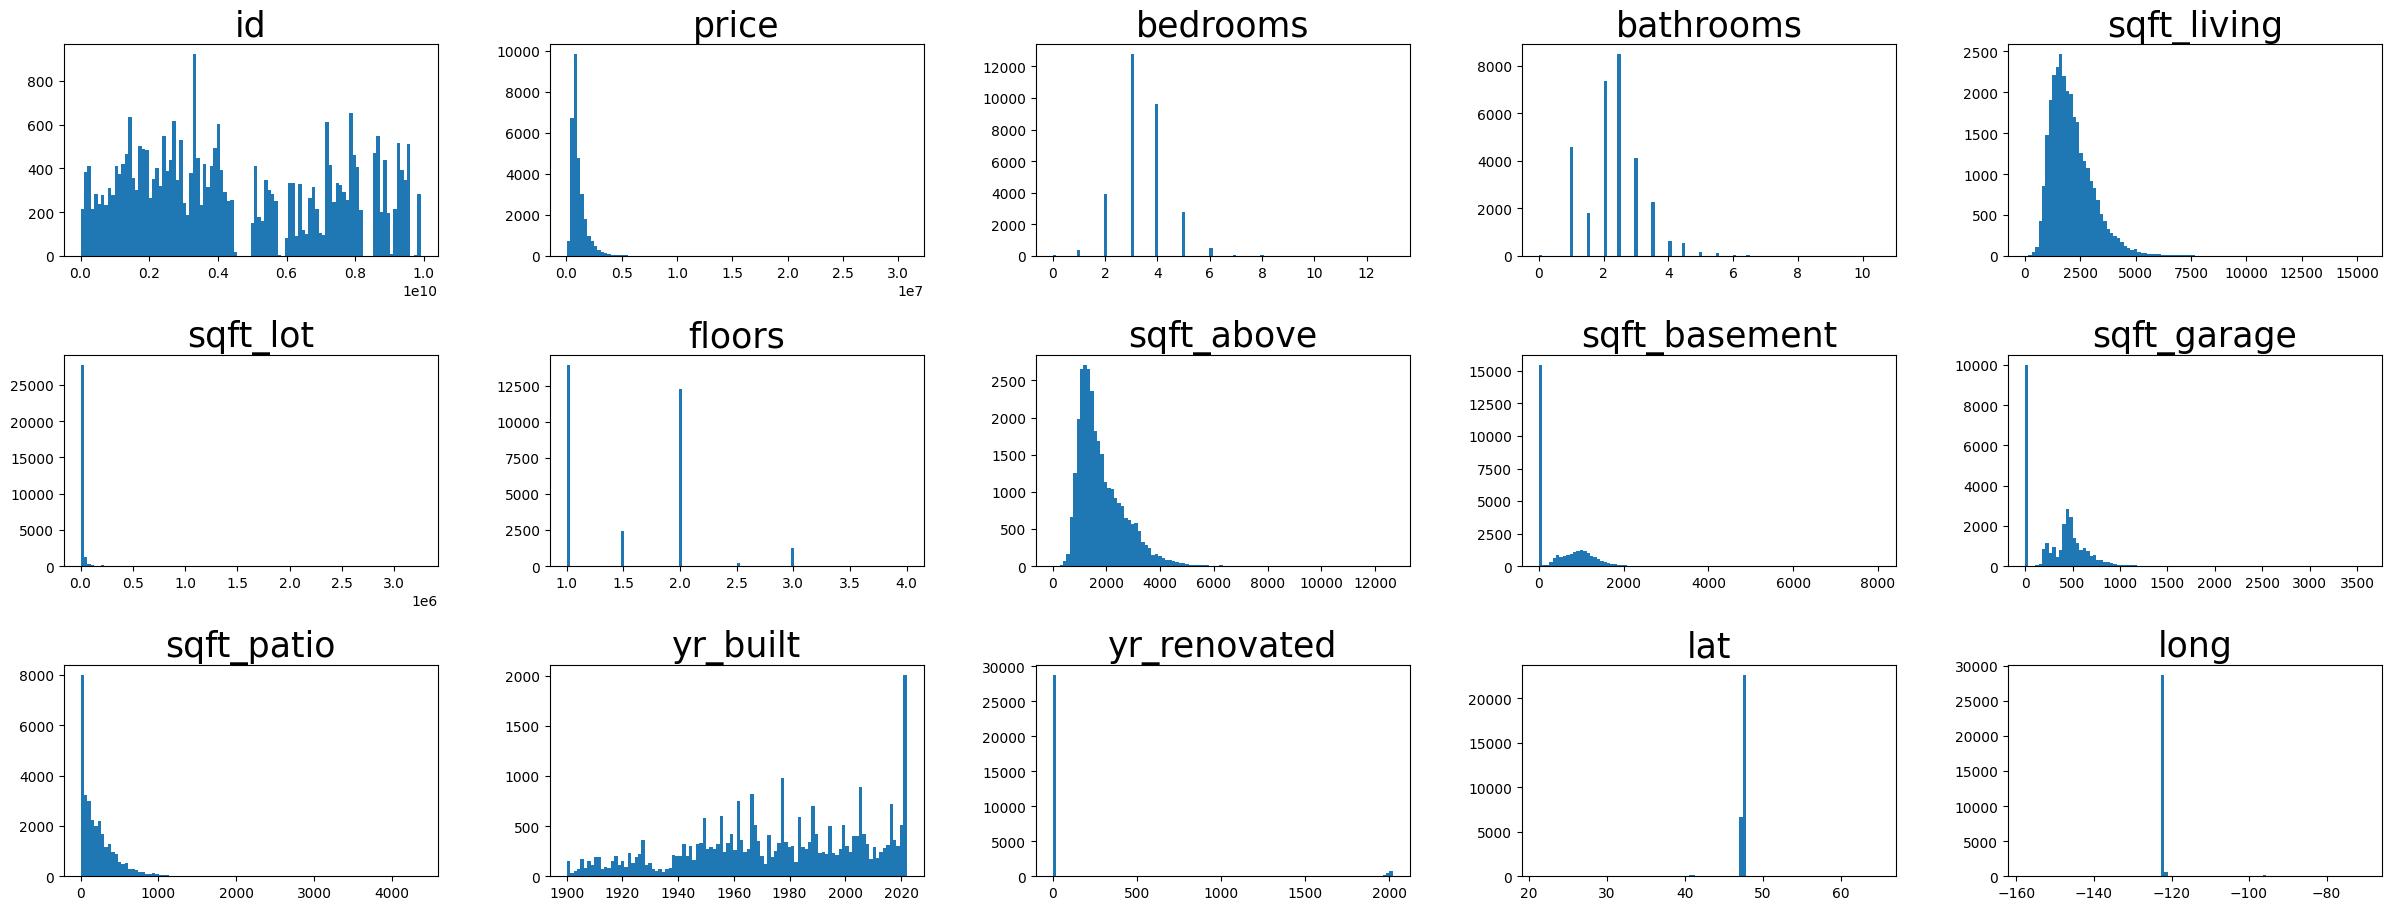

In [10]:
numerics = houses.select_dtypes(['int64', 'float64']) # Only selecting numeric variables
hist(numerics, numerics.columns)

In [11]:
# Removing outliers
houses = \
houses[
    (houses["price"]<5000000) &
    (houses["price"]>300000) &
    (houses["sqft_living"]>1000) &
    (houses["sqft_living"]<7000) &
    (houses["sqft_above"]>250) &
    (houses["sqft_above"]<6500) &
    (houses["sqft_lot"]<=75000) & 
    (houses['bedrooms']>0) & 
    (houses['bathrooms']>0) &
    (houses.long > -125) & 
    (houses.long < -121.6) & 
    (houses.lat > 47.1) & 
    (houses.lat<47.8)
]

In [12]:
# Removing all variable categories with <10 values
# houses = value_counts(houses)

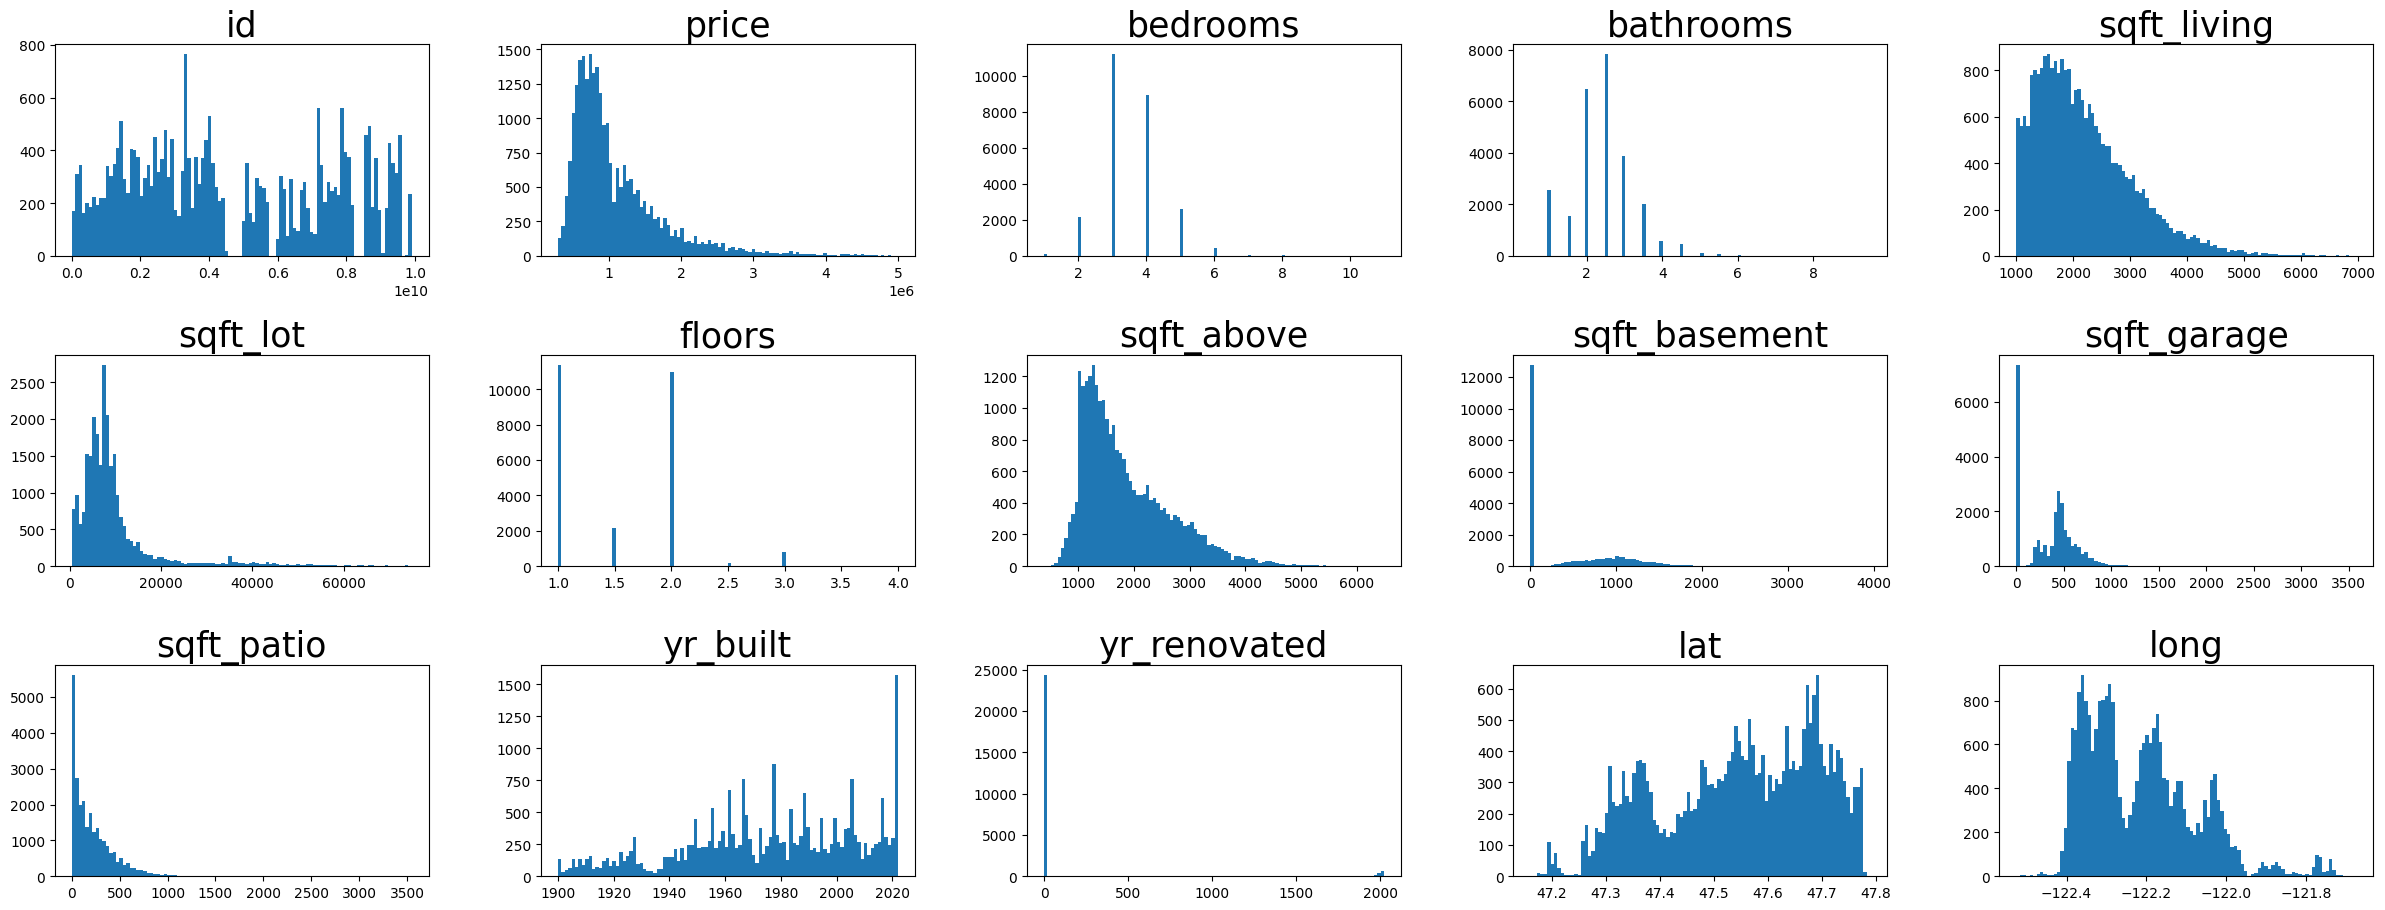

In [13]:
numerics = houses.select_dtypes(['int64', 'float64'])
hist(numerics, numerics.columns)

# Feature Engineering

In this section we will create numerous new variables for testing in the linear regression model.
This is done in an attempt to find other factors that have an influence on house price, in the hope of creating a more successful model.

- The square footage columns for patios, basements and garages have many zeros in them; each zero means the house does not have a patio, basement, or garage (depending on which column you're viewing). These columns weren't very predictive of a house's price (I omit the calculations in this project, but you can find out for yourself), so I used them to create new binary variables for patios, basements, and garages, where a 0 means a house doesn't have one and a 1 means a house does have one.

- I re-mapped some categorical variables to be numerical or binary variables. I wanted to limit myself to numeric variables in this project, because it makes things easier. The "condition", "view", and "grade" variables were among the variables I re-mapped; all made sense as numerical variables, so my changes were justified.

- A similar column for yr_renovated. The original column either had the year for a house's renovation, or a 0, meaning the house was never renovated. This column was also not very predictive of price, so I created a new binary variable dictating whether or not a house was renovated at all, in the hope this variable would be a better predictor of price.

- A coordinate variable which just combines the lat/long columns to form tuples. This variable was not used in any of the models; it was used to create four other variables which were candidates for inclusion in the model.
    - vicinity_price: takes each house in the dataset and computes the average price of nearby homes with similar dimensions using the latitude/longitude data.
    - vicinity_density: takes each house in the dataset and computes the number of houses in a small surrounding region. This is a measure of how crowded the house's region is.
    - distance_from_center: computes the house's distance from the center of inhabited territory in King County, WA (the vanishingly small number of houses on the fringes of King County were eliminated before determining the center, as were any houses outside of King County accidentally included in the dataset.)
    - distance_from_bellevue: computes the house's distances from a small area in King County, WA where the houses are the most expensive on average. After looking at a heat map of house price in King County, it seemed like there was a small region where house price jumped way up, and it seemed to go down as you got further away from this region. This region was located in a city called Bellevue, thus the name for the variable.

In [14]:
# Turning several continuous variables into boolean variables
houses['patio'] = houses['sqft_patio'].map(lambda x: 0 if x == 0 else 1)
houses['basement'] = houses['sqft_basement'].map(lambda x: 0 if x == 0 else 1)
houses['garage'] = houses['sqft_garage'].map(lambda x: 0 if x == 0 else 1)
houses['renovated'] = houses['yr_renovated'].map(lambda x: 0 if x==0 else 1)

# Turning the following categorical variables into numeric variables
houses['condition'] = houses['condition'].map({'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4})
houses['waterfront'] = houses['waterfront'].map({'NO': 0, 'YES': 1})
houses['greenbelt'] = houses['greenbelt'].map({'NO': 0, 'YES': 1})
houses['nuisance'] = houses['nuisance'].map({'NO': 0, 'YES': 1})
houses['view'] = houses['view'].map({'NONE': 0, 'AVERAGE': 1, 'GOOD': 2, 'EXCELLENT': 3, 'FAIR': 4})
houses['grade'] = houses['grade'].map(lambda x: x.split(" ")[0]).astype(int)

# Creating a "coordinate" variable in a lat/long tuple format.
houses['coordinate'] = list(zip(houses['lat'], houses['long']))

# This calculates the distance of every house from the center of inhabited territory.
center = ((houses.lat.min() + houses.lat.max())/2), ((houses.long.min() + houses.long.max())/2)
houses['distance_from_center'] = houses['coordinate'].map(lambda x: geopy.distance.geodesic(x, center).km)

highest_price = (47.62637851929106, -122.22555549295355)
houses['distance_from_bellevue'] = houses['coordinate'].map(lambda x: geopy.distance.geodesic(x, highest_price).km)

In [15]:
# Calculating the vicinity_price_ls variable.
# Averages the price of similar homes in a nearby region
# Does this for every single house in the dataset

lat_square, long_square = 0.01, 0.01 # Boundaries for region
vicinity_means = []

for i in range(len(houses)):
    lat, long = houses.iloc[i].lat, houses.iloc[i].long
    identifier = houses.iloc[i].id
    sqft = houses.iloc[i].sqft_living
    upper = sqft+500
    lower = sqft-500
    
    # Gathers all similar homes in a surrounding region
    # Eliminates the house in question so it doesn't predict
    # its own price
    area = houses[(houses.lat < lat+lat_square) & 
                  (houses.lat > lat-lat_square) & 
                  (houses.long < long+long_square) & 
                  (houses.long > long-long_square) & 
                  (houses.id != identifier)]
        
    vicinity_means.append(area.price.mean())
    
    # This loop takes a second to run.
    # These outputs let us know how much is left to complete.
    clear_output(wait=True)
    print(f"cell number {i+1} out of {len(houses)} done.")

    percentage = (i+1)/len(houses) * 100
    print(f"{round(percentage, 2)}% complete.")
    

print("Features successfully engineered.")

# Creates new column.
houses['vicinity_price'] = vicinity_means

cell number 25548 out of 25548 done.
100.0% complete.
Features successfully engineered.


# Vicinity price calculation – Demonstration

The "vicinity price" for each house was calculated by taking the average of houses in a certain nearby region. This is an example of what that "nearby region" looks like for any given house.

Note to self: create nicer visualization for presentation.

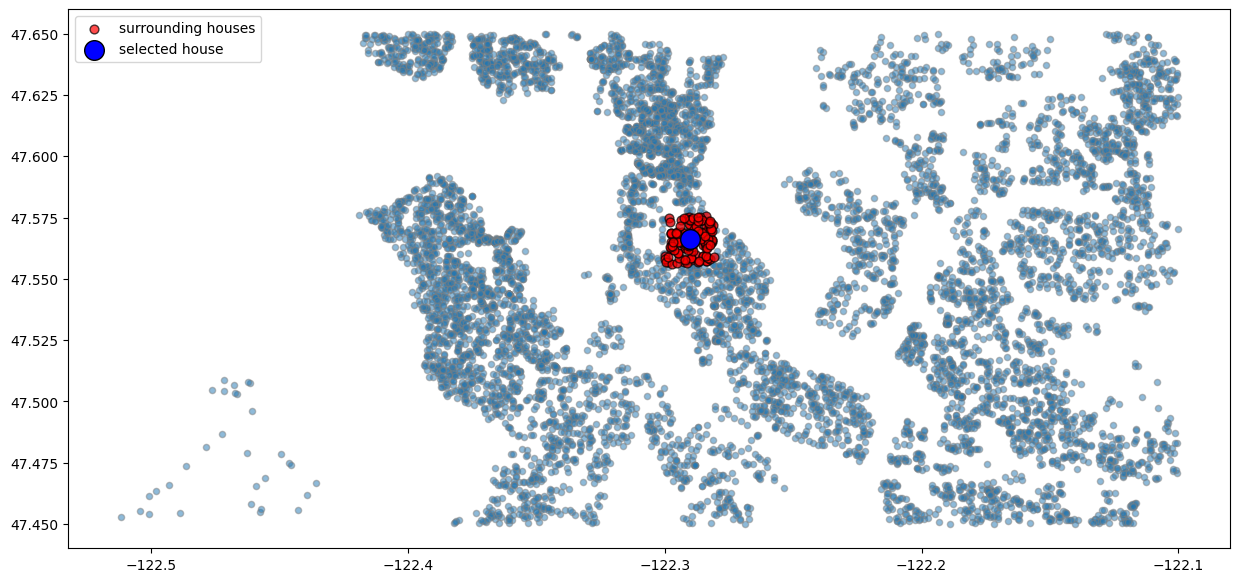

In [16]:
fig, ax = plt.subplots(figsize=(15,7))

lat_square, long_square, i = 0.01, 0.01, 3
lat, long = houses.iloc[i].lat, houses.iloc[i].long
area = houses[(houses.lat < lat+lat_square) & 
              (houses.lat > lat-lat_square) & 
              (houses.long < long+long_square) & 
              (houses.long > long-long_square) & 
              (houses.long != long) & 
              (houses.lat != lat)]

zoom = houses[(houses.lat < 47.65) & 
              (houses.lat > 47.45) & 
              (houses.long < -122.1) & 
              (houses.long > -122.53) & 
              (houses.long != long) & 
              (houses.lat != lat)]

ax.scatter(zoom.long, zoom.lat, s=20, alpha=0.5, edgecolor='gray')
ax.scatter(area.long, area.lat, s=40, color='red', alpha=0.7, edgecolor='black', label='surrounding houses')
ax.scatter(houses.iloc[i].long, houses.iloc[i].lat, s=200, color='blue', edgecolor='black', label='selected house')

ax.legend()

# plt.axvline(x=long+long_square)
# plt.axvline(x=long-long_square)
# plt.axhline(y=lat+lat_square)
# plt.axhline(y=lat-lat_square)

In [17]:
# Calculates the densities variable.
# This is a measure of how crowded the area around each house is.

densities = []

for i in range(len(houses)):
    lat, long = houses.iloc[i].lat, houses.iloc[i].long
    identifier = houses.iloc[i].id
    
    # Selects all nearby houses
    area = houses[(houses.lat < lat+lat_square) & 
                  (houses.lat > lat-lat_square) & 
                  (houses.long < long+long_square) & 
                  (houses.long > long-long_square) & 
                  (houses.id != identifier)]
    
    # Appends the number of nearby houses to our list
    densities.append(len(area))
    
    # This loop takes a second to run.
    # These outputs let us know how much is left to complete.
    clear_output(wait=True)
    print(f"cell number {i+1} out of {len(houses)} done.")
    
    percentage = (i+1)/len(houses) * 100
    print(f"{round(percentage, 2)}% complete.")

print("Features successfully engineered.")

# Creates new column.
houses['density'] = densities

cell number 25548 out of 25548 done.
100.0% complete.
Features successfully engineered.


In [18]:
# Several of the features we created were computationally intensive and took a while to complete.
# To avoid having to repeat these procedures, we duplicate the dataframe and any changes we want
# to make can be done on this duplicated dataframe.
df = houses.copy()

In [19]:
# Removes all null values.
df.dropna(inplace=True)

to_drop = ['id', 'date', 'yr_renovated', 
         'lat', 'long', 'coordinate', 'address']

usable_vars(df, to_drop)

The list of variables we can use in the linear regression model is: 

 ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built', 'patio', 'basement', 'garage', 'renovated', 'distance_from_center', 'distance_from_bellevue', 'vicinity_price', 'density']


# Non-linear relationships with price

One of the assumptions of linear regression is linearity – the independent variables selected must have an approximately linear relationship with price. We look at all the available numeric variables to see which have linear relationships with price, and which ones don't.

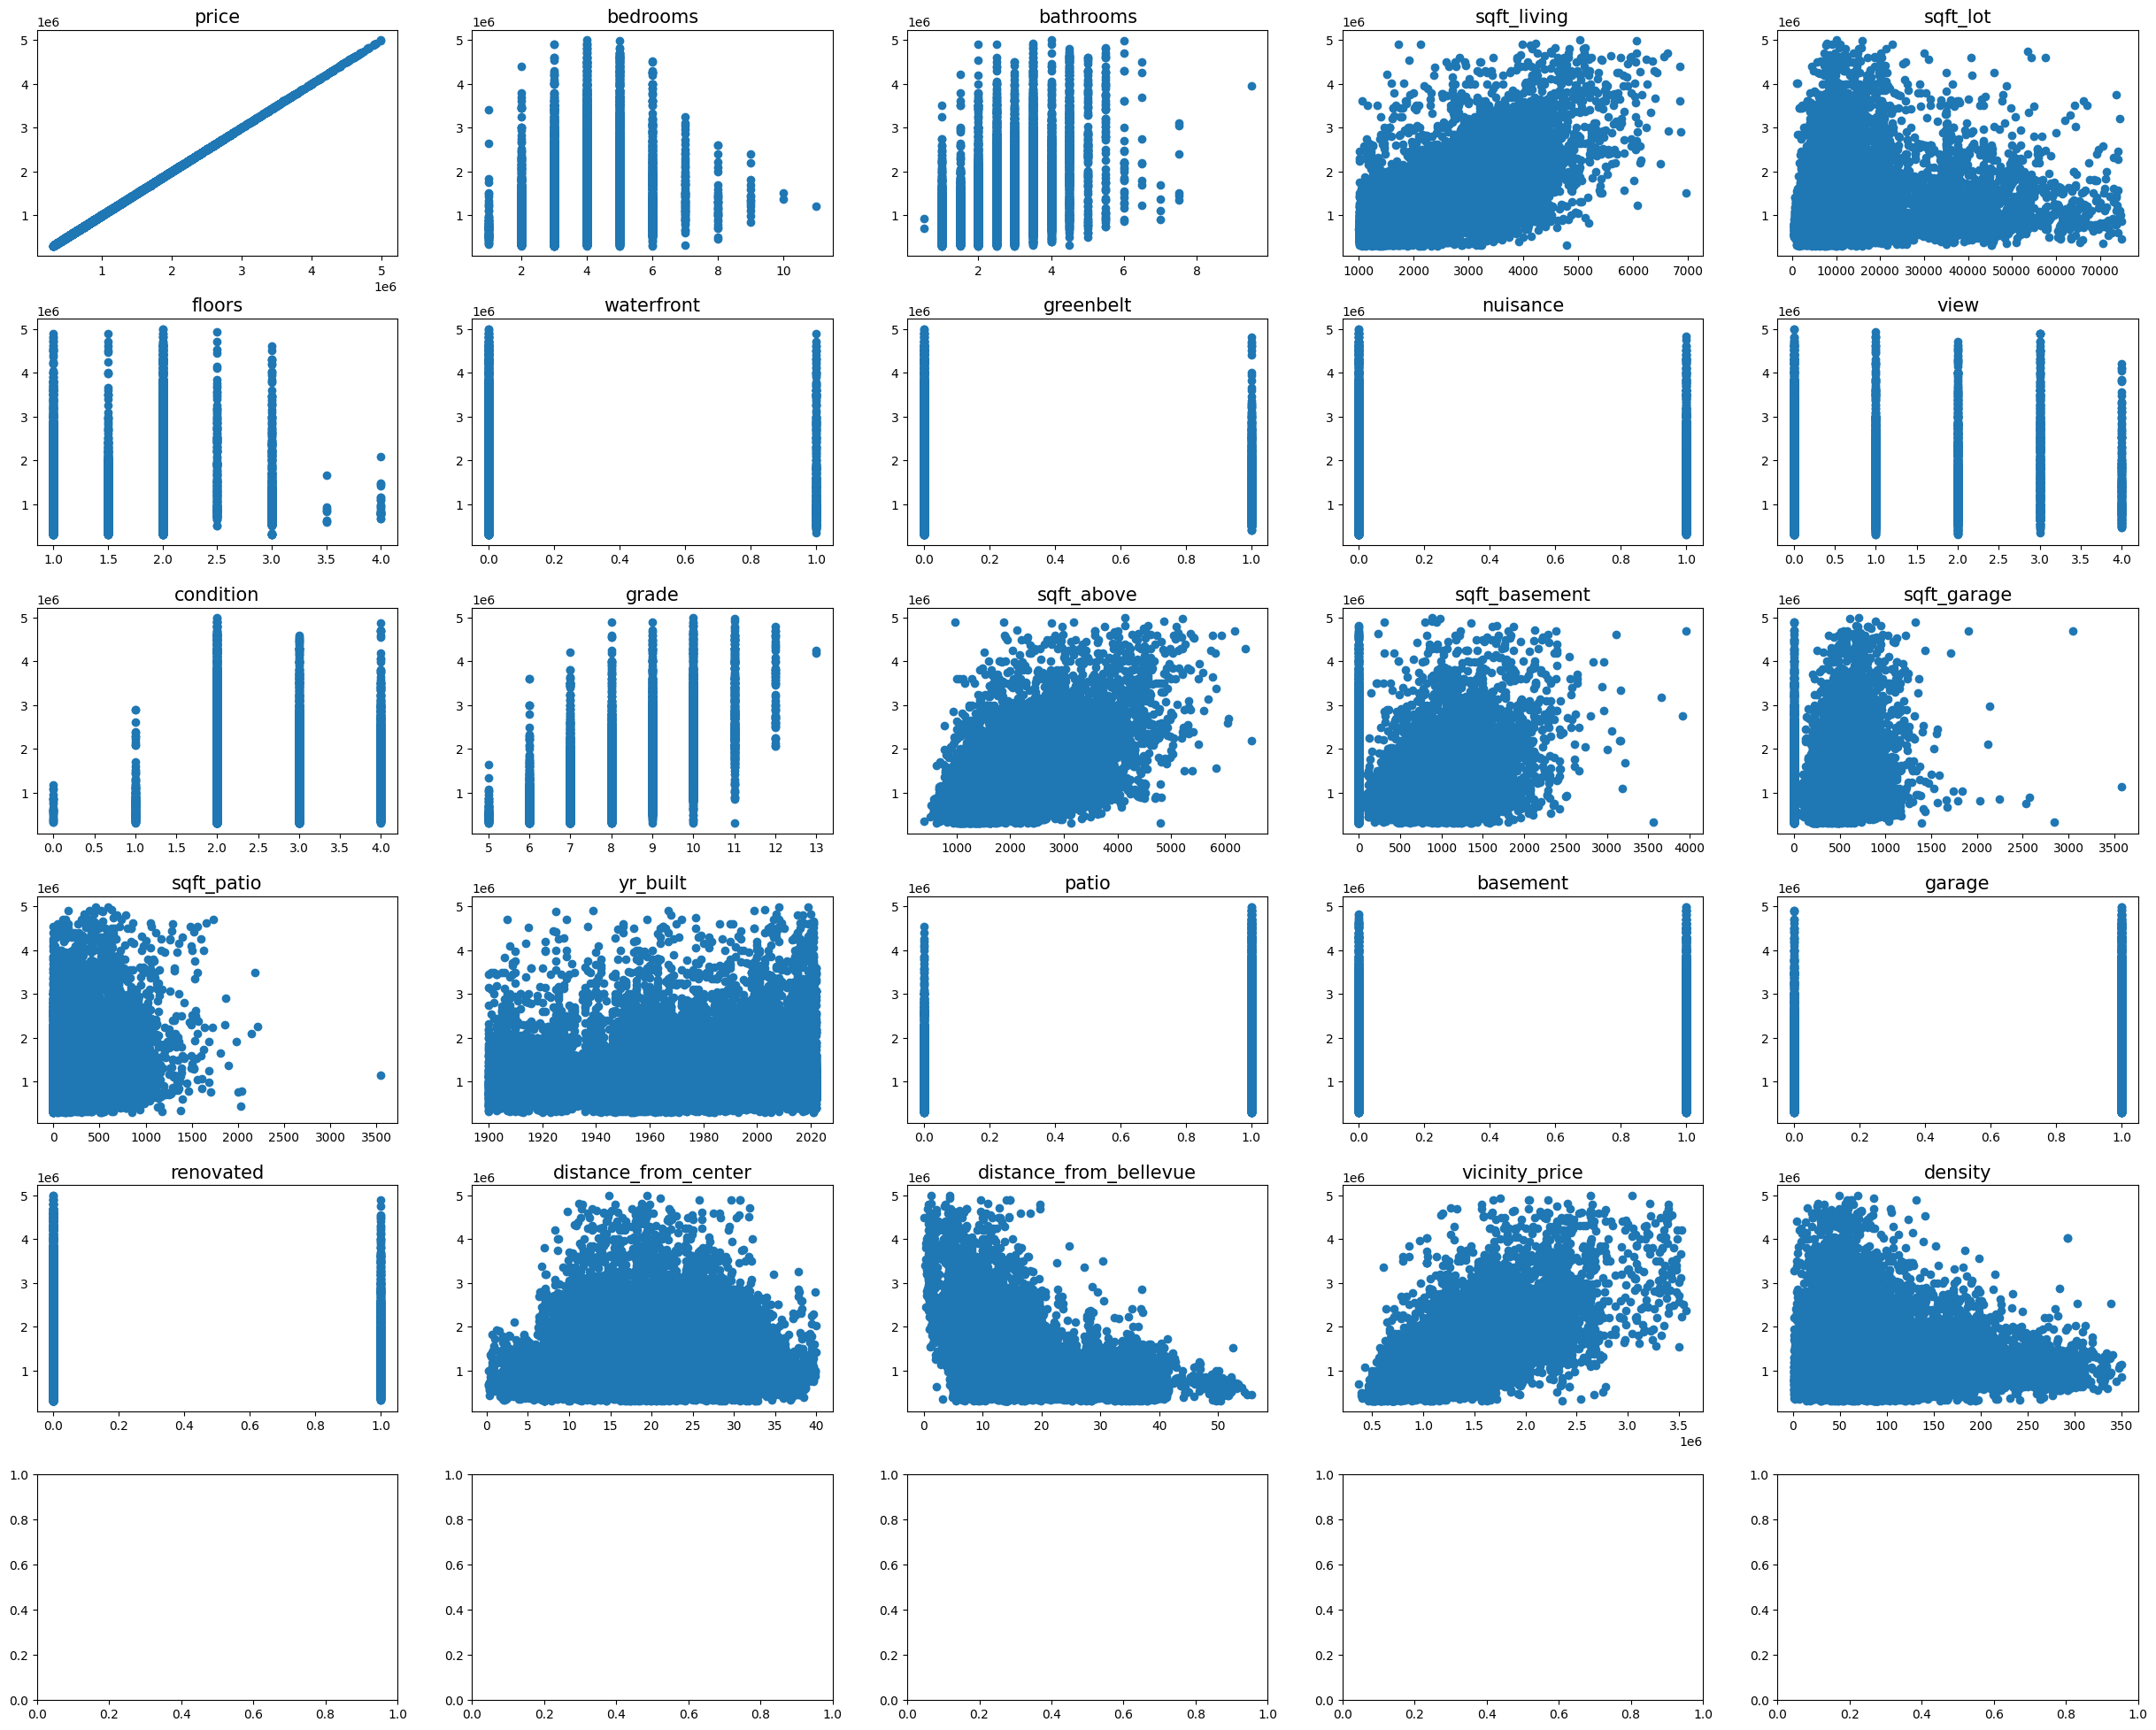

In [20]:
graph_df = df.drop(to_drop, axis=1).select_dtypes(include=['float64', 'int64'])
scatter(graph_df, graph_df.columns)

### Variables that do not have a linear relationship with price

- bedrooms
- sqft_lot
- floors
- view
- density
- distance_from_center

### Other variables we will not use

- sqft_basement (too many zeros)
- sqft_garage (too many zeros)
- sqft_patio (too many zeros)
- yr_renovated (too many zeroes)
- latitude (already served its purpose)
- longitude (already served its purpose)

In [21]:
to_drop += ['bedrooms', 'floors', 'sqft_basement', 
            'sqft_garage', 'sqft_patio', 'yr_built', 
            'distance_from_center']

usable_vars(df, to_drop)

The list of variables we can use in the linear regression model is: 

 ['price', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above', 'patio', 'basement', 'garage', 'renovated', 'distance_from_bellevue', 'vicinity_price', 'density']


# Eliminating Collinearity and Weak Variables

Another assumption of linear regression is that the independent variables used in the model are not collinear; that is, they are not highly correlated with each other. I do not attempt to completely eliminate collinearity, as all the variables are correlated with each other to a certain degree.

However, I draw the line at a correlation of 0.7 or -0.7 between independent variables. No two variables that are this highly correlated can be included in the model; at most, you can pick one.

Also, I have no interest in using variables that have little to no impact on price. Any variable that has an adjusted R-Squared of less than 0.1 in a linear regression model will be eliminated from consideration in our model.

In [22]:
# This will show us what variables are strong predictors of price in a linear regression model.
# Of course, price predicts itself with 100% accuracy.

strengths = variable_strength(df.drop(to_drop, axis=1), df.drop(to_drop, axis=1).columns)
strengths

,variables,rsquared_adj
0,price,1.000000
18,vicinity_price,0.570340
2,sqft_living,0.425596
9,grade,0.398567
12,sqft_above,0.315154
1,bathrooms,0.246317
17,distance_from_bellevue,0.204079
7,view,0.079399
10,heat_source,0.030049
13,patio,0.025004


In [23]:
to_drop += ['view', 'heat_source', 'patio', 
            'sqft_lot', 'waterfront', 'renovated', 
            'basement', 'greenbelt', 'garage', 
            'density', 'sewer_system', 'nuisance', 
            'condition']

In [24]:
# Thisshows us which variables are highly correlated with each other.

df.drop(to_drop, axis=1).corr(numeric_only = True)

,price,bathrooms,sqft_living,grade,sqft_above,distance_from_bellevue,vicinity_price
price,1.000000,0.496333,0.652394,0.631340,0.561410,-0.451786,0.755220
bathrooms,0.496333,1.000000,0.728977,0.579809,0.614601,-0.047827,0.275557
sqft_living,0.652394,0.728977,1.000000,0.688949,0.851747,-0.046860,0.381346
grade,0.631340,0.579809,0.688949,1.000000,0.676112,-0.142998,0.459411
sqft_above,0.561410,0.614601,0.851747,0.676112,1.000000,0.074906,0.314399
distance_from_bellevue,-0.451786,-0.047827,-0.046860,-0.142998,0.074906,1.000000,-0.601953
vicinity_price,0.755220,0.275557,0.381346,0.459411,0.314399,-0.601953,1.000000


#### Variables we are not using due to high collinearity

- bathrooms
- grade
- sqft_above
- zipcode_price

#### Variables we are not using due to having an adjusted r-squared value of <0.1 in a linear regression model

- waterfront
- heat_source
- patio
- vicinity_density
- garage
- basement
- yr_built
- renovated
- greenbelt
- sewer_system
- condition
- nuisance

In [25]:
to_drop += ['sqft_living', 'price']
usable_vars(df, to_drop)

The list of variables we can use in the linear regression model is: 

 ['bathrooms', 'grade', 'sqft_above', 'distance_from_bellevue', 'vicinity_price']


# Choice of visualizations

#### Actual vs. predicted values
This plots the original prices with the predicted prices. Ideally, the original prices would be the same as the predicted prices; this would mean we have a perfect model. Of course, this is never going to happen; the best we can hope for is that the predicted values approximate the original ones. This visuzliation lets us see how close our predictions are to reality. The closer the blue dots are to the black line, the better they are.

#### QQ Plot
Once again, the better the model is, the closer the blue dots will be to the black line.

#### Residuals vs. fitted values
This allows us to test for homoscedasticity of errors, which is an assumption of linear regression. If our errors (how off we are in each prediction) are homoscedastic, there will be no wild changes in how the errors are distributed across the model.

#### Residual distribution
Another assumption of linear regression is that our residuals are normally distributed. This histogram allows us to visually inspect for that.

# Model 1

This model is our most basic model: it only uses a single variable from the dataset. We chose our engineered feature **vicinity_price** because it had the highest adjusted r-squared value of any variable when used to predict price.

The adjusted R-Squared value is already at 0.764. The mean absolute error is at 194,210; this means, on average, our model's predictions are off by $194,210 dollars.

In [26]:
results1 = create_model("price ~ vicinity_price", df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                 3.384e+04
Date:                Sat, 15 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:21:45   Log-Likelihood:            -3.6673e+05
No. Observations:               25497   AIC:                         7.335e+05
Df Residuals:                   25495   BIC:                         7.335e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.859e+04   6666.252     -2.




MAE: 277611.65675940877
RMSE: 182179775351.1597


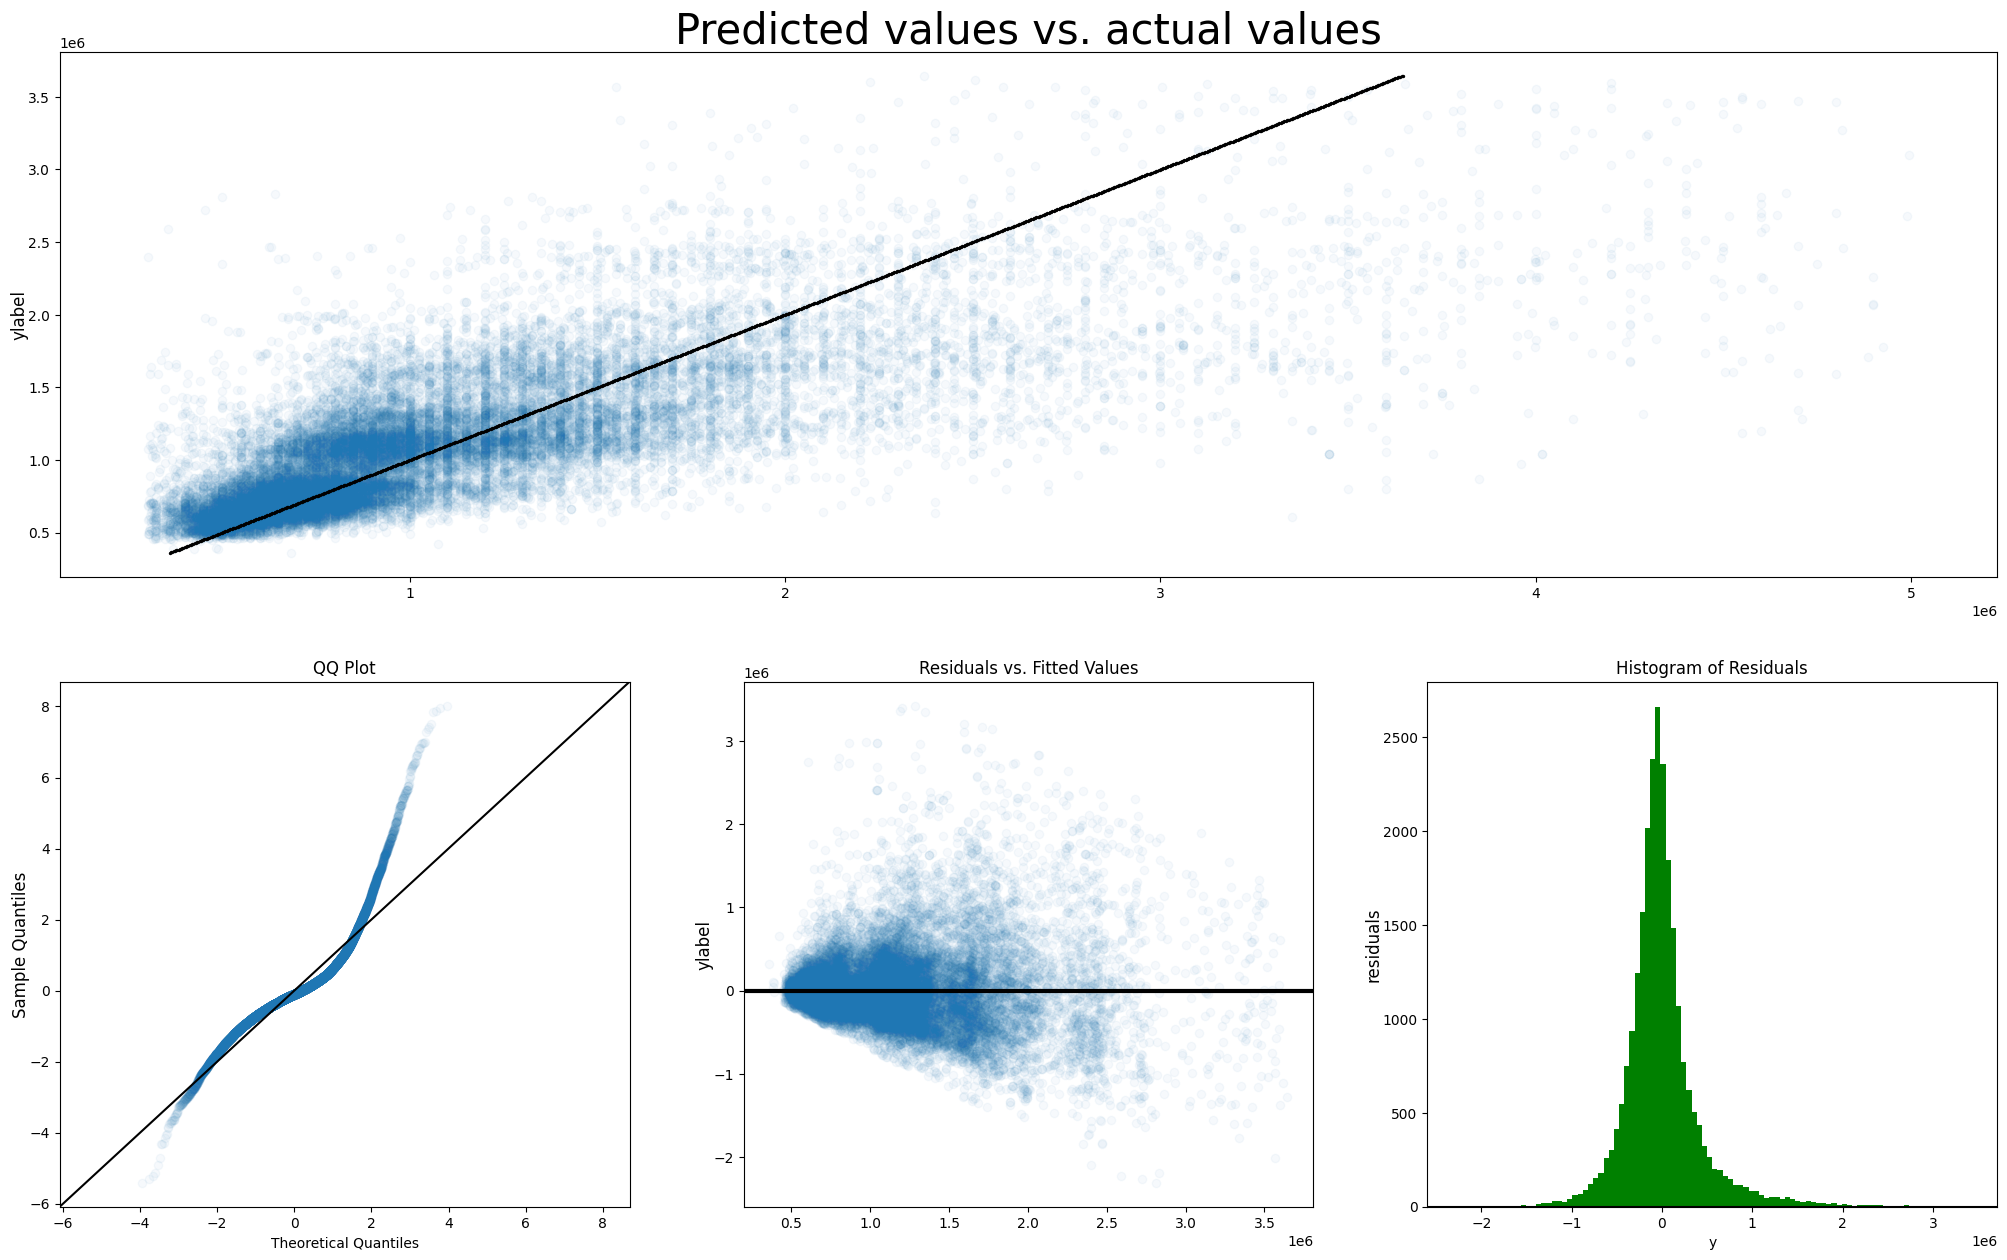

In [27]:
analyze_model(results1, df)

# Model 2

I had to find a way to improve the model metrics, especially the MAE and RMSE. To do so, I used all the acceptable variables in the linear regression formula: vicinity_price, distance_from_bellevue, and sqft_living.

Our adjusted R-Squared value increased from 0.764 to 0.775, a significant improvement. Our mean absolute error and root mean squared error also went down but not by much.

The MAE went down only 3000 dollars.

In [28]:
results2 = create_model("price ~ vicinity_price + grade + sqft_living", df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                 2.352e+04
Date:                Sat, 15 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:21:46   Log-Likelihood:            -3.6058e+05
No. Observations:               25497   AIC:                         7.212e+05
Df Residuals:                   25493   BIC:                         7.212e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -9.662e+05   1.75e+04    -55.




MAE: 222311.72279622135
RMSE: 112526842519.69064


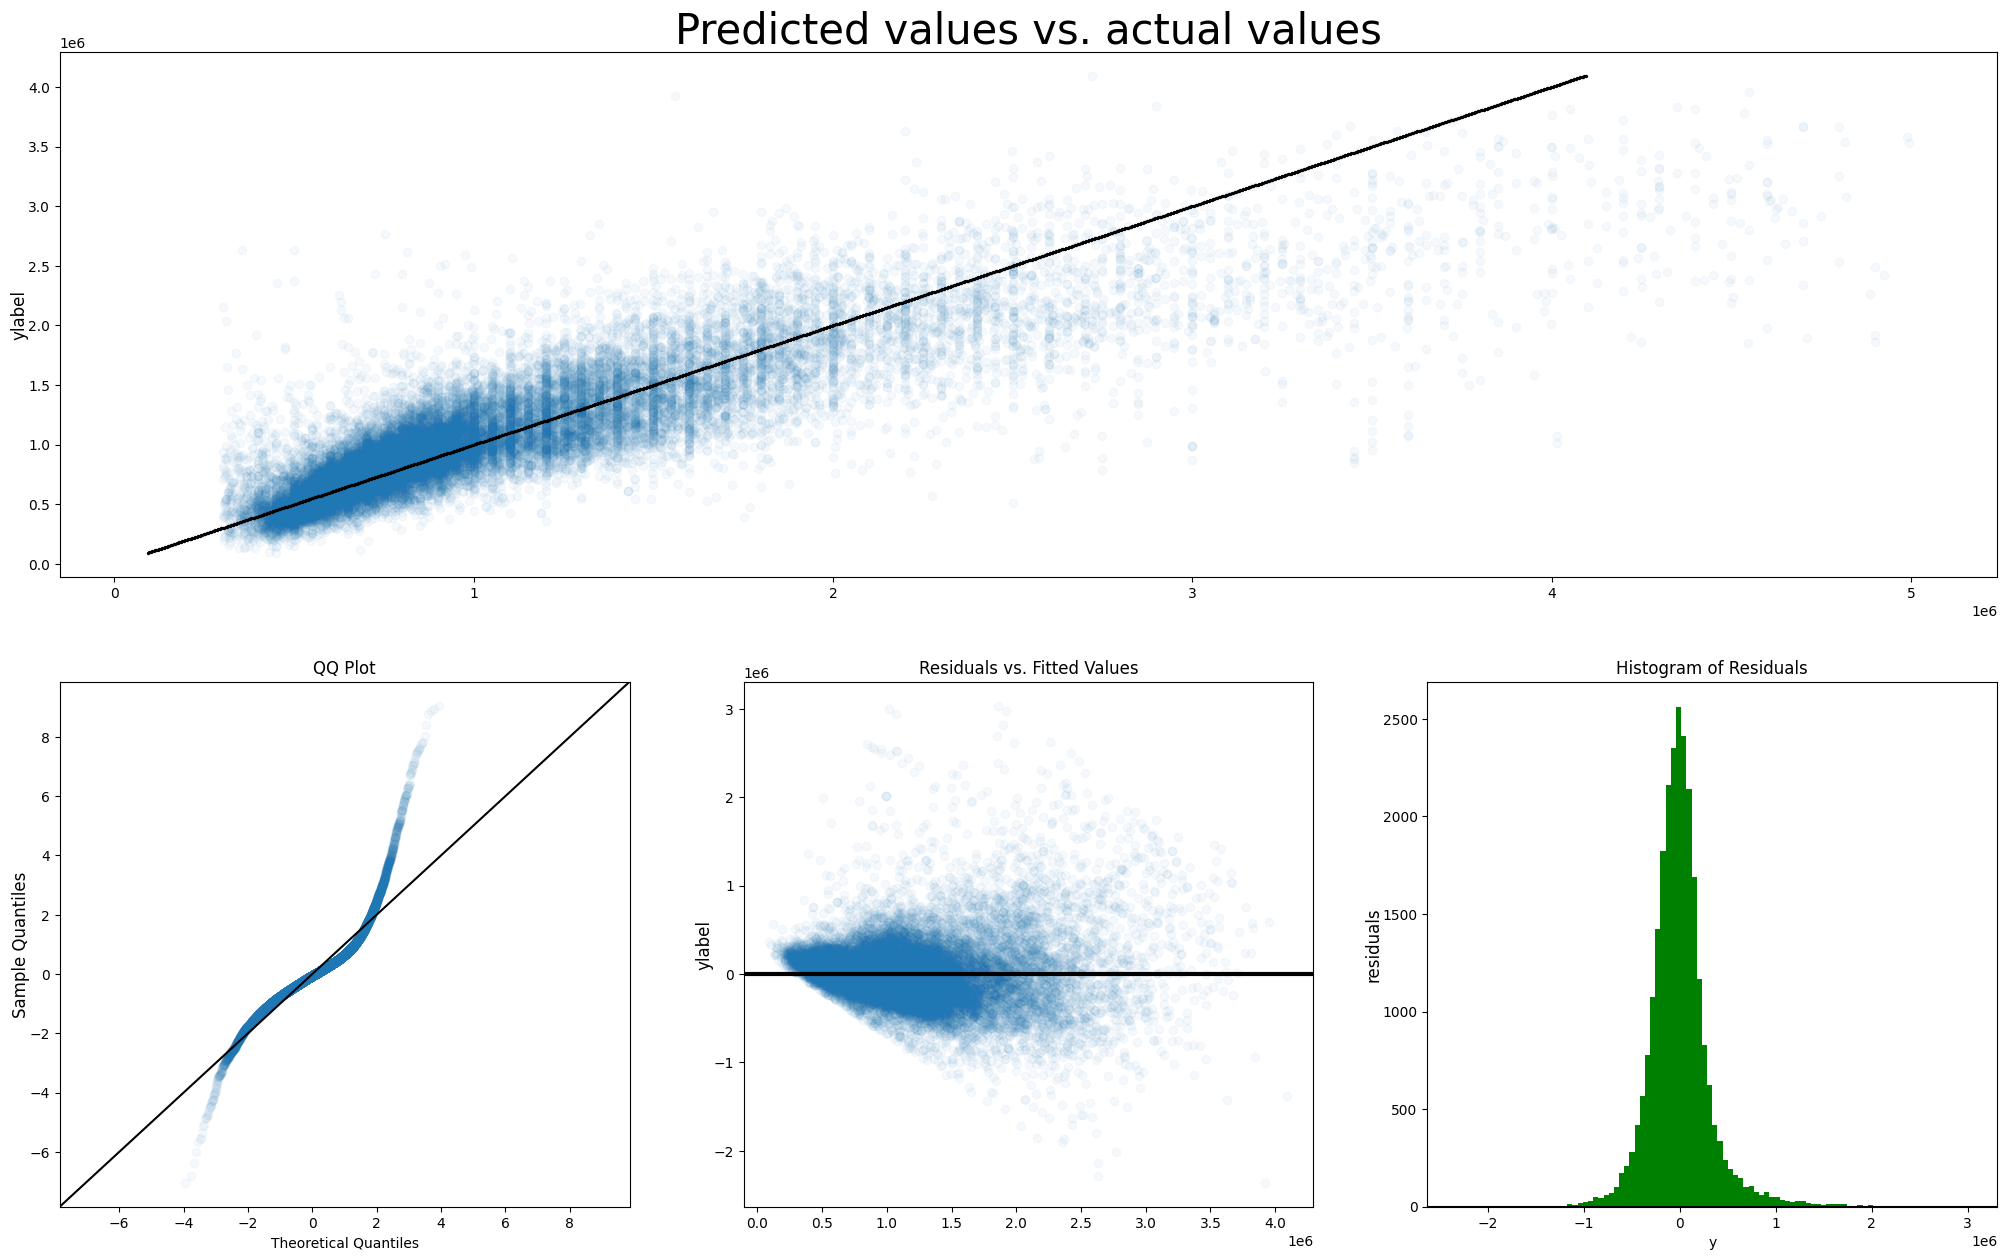

In [29]:
analyze_model(results2, df)

# Model 3

Although our model metrics are acceptable, the coefficients and intercept need to be interpretable. The interpretation of the second model would be something like:

"A house surrounded by similar homes priced at 0 dollars, with a grade of 0 and no square feet, would cost negative fifty-thousand dollars." This makes no sense

In this model, I mean-center several columns to make the model more interpreable. I also divide the house and vicinity price by 100,000 to make the coefficients and error-based metrics more interpretable.

In [33]:
centerdf = df.copy()

to_center = ['vicinity_price', 'grade', 'sqft_living']
for col in to_center:
    mean = centerdf[col].mean()
    centerdf[col] = centerdf[col].map(lambda x: x-mean)
    
to_divide = ['price', 'vicinity_price']
for col in to_divide:
    centerdf[col] = centerdf[col]/100000

In [34]:
results3 = create_model("price ~ vicinity_price + grade + sqft_living", centerdf)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                 2.352e+04
Date:                Sat, 15 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:23:15   Log-Likelihood:                -67038.
No. Observations:               25497   AIC:                         1.341e+05
Df Residuals:                   25493   BIC:                         1.341e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.0488      0.021    525.




MAE: 2.2231172279622795
RMSE: 11.252684251969061


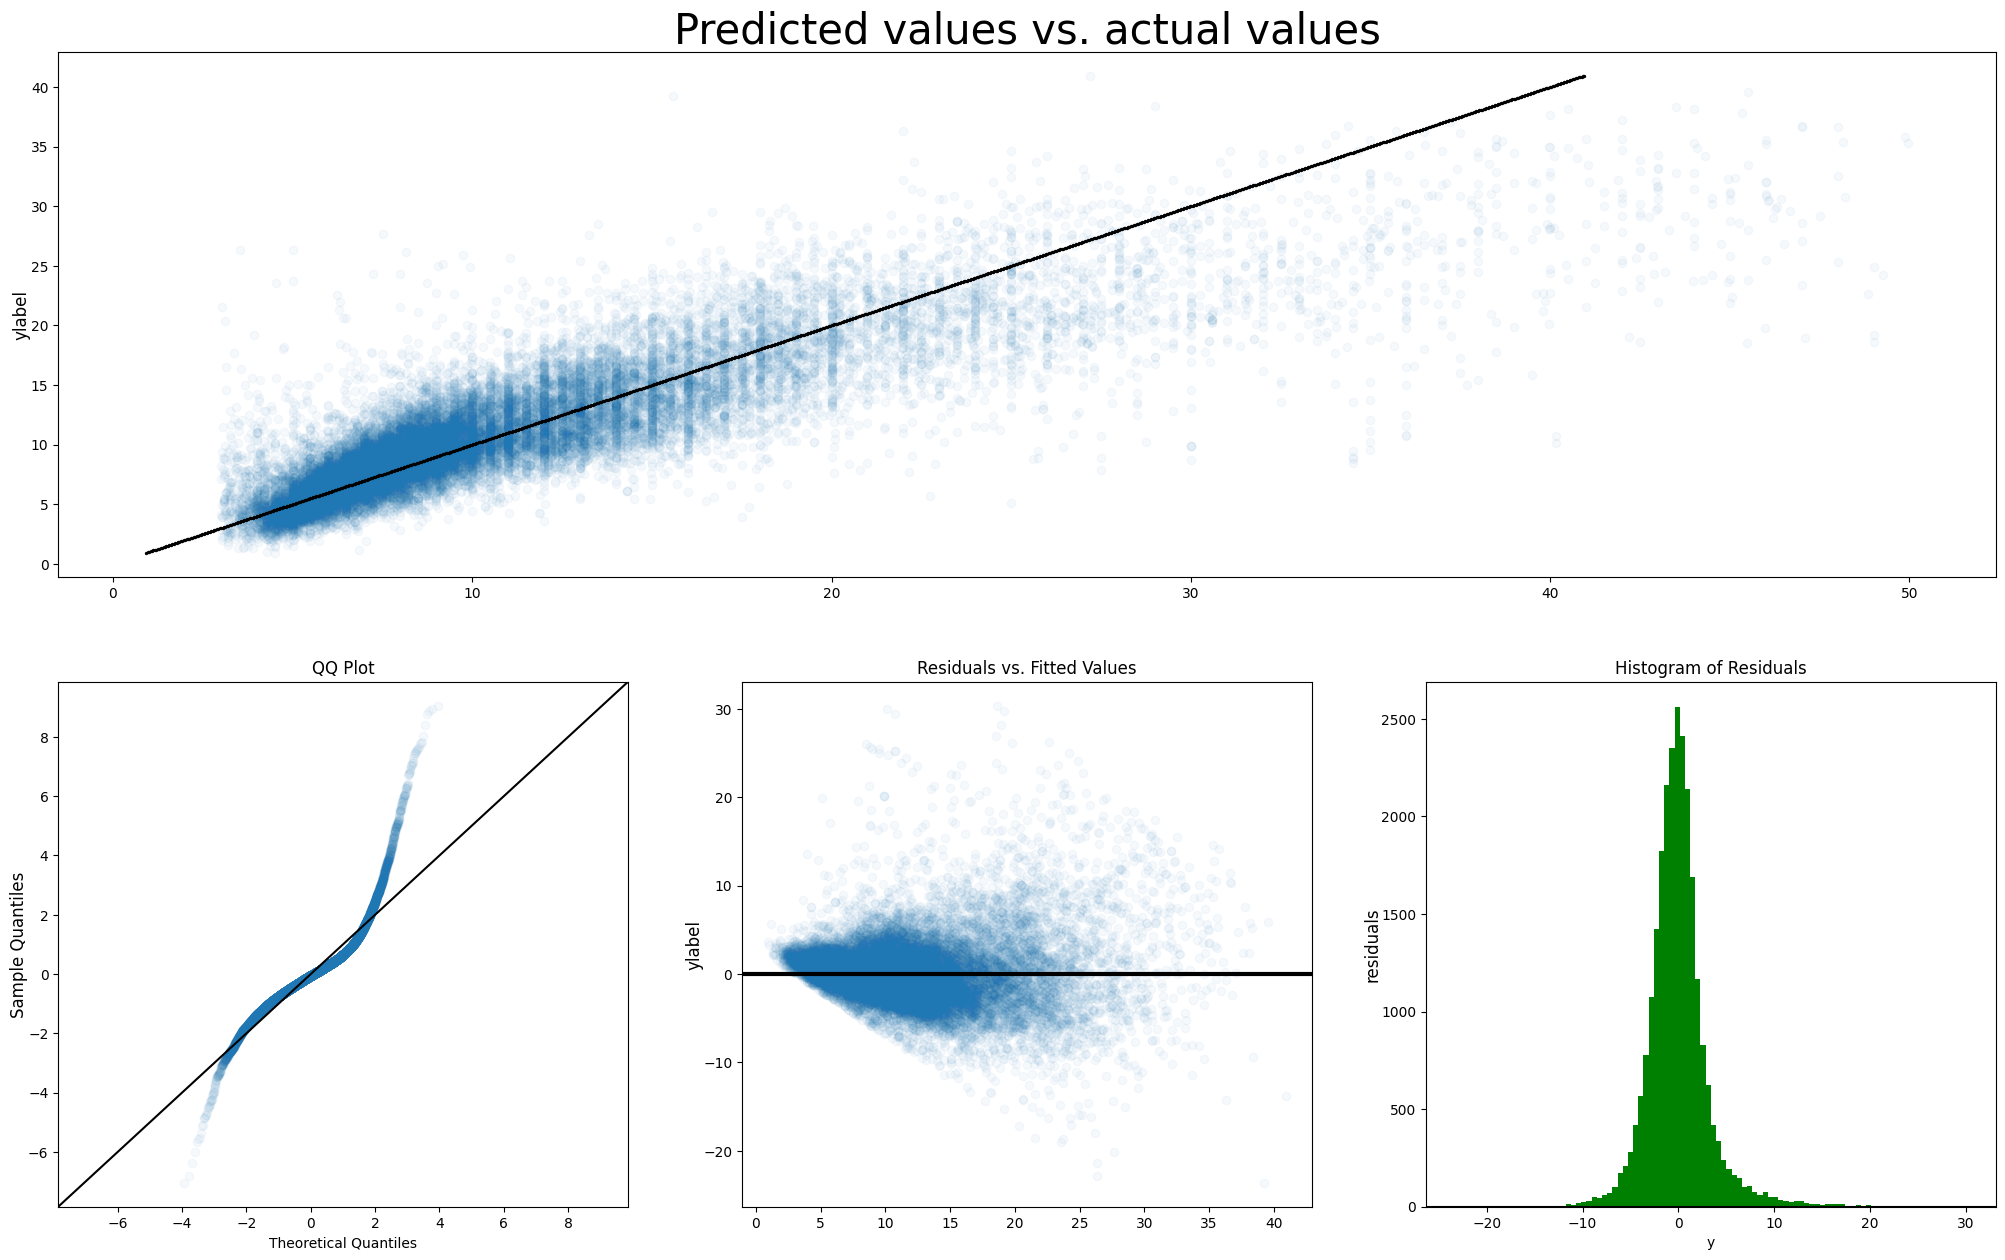

In [35]:
analyze_model(results3, centerdf)

# Interpretation of our Final Model


### Coefficients and error-based metrics
A house surrounded by homes all with average prices, with an average grade, and average square footage of living space, costs about 1.1 million dollars.

For every dollar increase in the price of homes in the house's vicinity, the house's price goes up by 76.3 cents.

Every increase in grade leads to an increase of $84,800 in house price.

Every additional square foot above grade leads to an increase of $260 dollars in house price.

On average, our model's predictions are off by about $220,000 dollars.

### Failures of our model
The average error is higher than you'd want; ideally, it would be lower than $100,000 dollars. Our data is too limited to create a better model.

Furthermore, despite eliminating variables with non-linear relationships to house price, collinear variables, outliers, and achieving normally distributed residuals, we were unable to get completely homoscedastic errors. Although they aren't terrible, we would like them to be more uniformly distributed.

By no means does this make our model un-usable; after all, we satisfied 95% or more of what linear regression requires. I believe this model can still yield useful insights.

# Recommendations

- Each increase in grade raises the home's price by about $85,000. If it's possible to increase the home's grade for less than that amount, it will result in a profit.

- Buy homes where surrounding homes are likely to increase in value.

- Our model is not perfect by any means and we encourage the stakeholders to only take this as preliminary advice, and to use other models in addition to ours before making investments.